In [1]:
from myfunc import stochastic, finfunc
import pandas as pd

In [2]:
# グラフ、桁数表記設定
from myfunc.utility import pref
pref()

<AxesSubplot:>

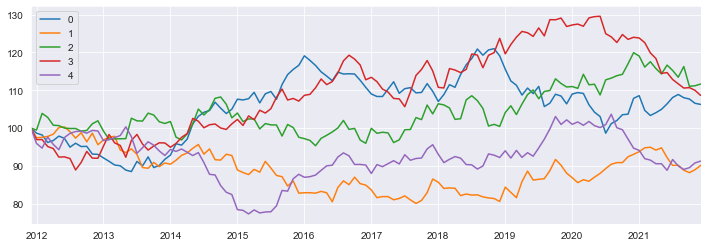

In [3]:
# パスの生成
gbm = stochastic.geometric_brownian_motion(M=120, npath=5)
dates = pd.date_range(end='2021-12-31', periods=len(gbm), freq='BM')
df = pd.DataFrame(gbm, index=dates)
df.plot()

In [4]:
ts = pd.DataFrame({'price': df.iloc[:, 0]})
ts['return'] = ts['price'].pct_change()
ts['hwm']=finfunc.high_water_mark(ts['price'],window=12)
ts['mdd']=finfunc.max_draw_down(ts['price'],window=12)
ts

,price,return,hwm,mdd
2011-12-30,100.000000,NaN,100.000000,0.000000
2012-01-31,98.650584,-0.013494,100.000000,-0.013494
2012-02-29,98.173794,-0.004833,100.000000,-0.018262
2012-03-30,96.197844,-0.020127,100.000000,-0.038022
2012-04-30,96.694812,0.005166,100.000000,-0.033052
...,...,...,...,...
2021-08-31,108.879843,0.007416,108.879843,0.000000
2021-09-30,108.018800,-0.007908,108.879843,-0.007908
2021-10-29,107.678296,-0.003152,108.879843,-0.011036
2021-11-30,106.546297,-0.010513,108.879843,-0.021432


In [5]:
df.apply(lambda x: finfunc.hurst(x.dropna()))

0    0.162359
1    0.015844
2    0.114821
3    0.353572
4    0.170585
dtype: float64

(<Figure size 864x288 with 1 Axes>, <Figure size 864x288 with 1 Axes>)

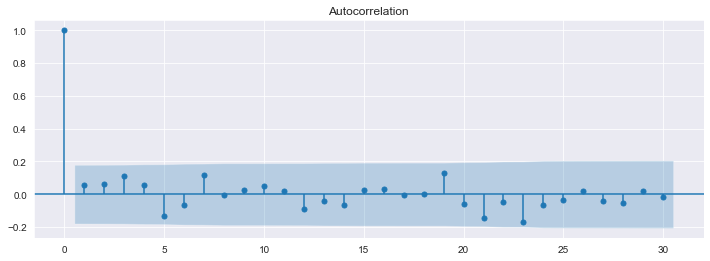

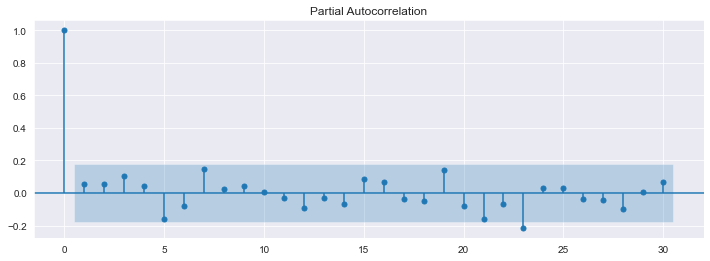

In [5]:
ts_r = ts['return'].dropna()
finfunc.acf_plot(ts_r)

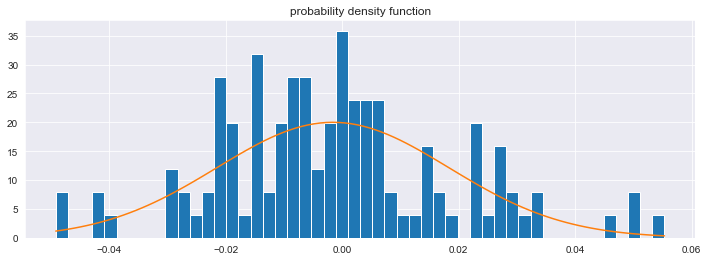

In [7]:
finfunc.histgram_pdf(ts_r)

<AxesSubplot:xlabel='freq/y'>

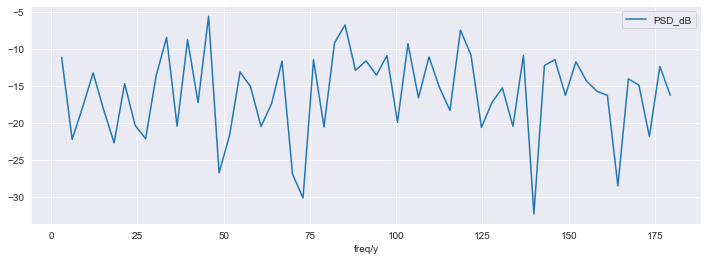

In [8]:
finfunc.fast_Fourier_transform_psd(ts_r.values).plot(legend=True)

<AxesSubplot:>

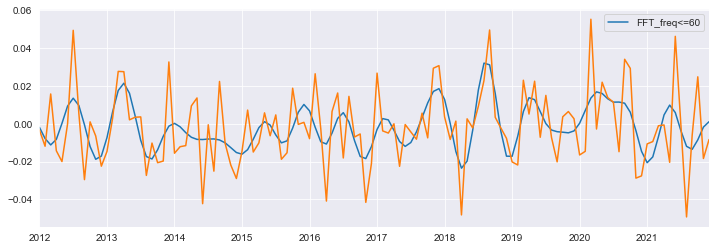

In [9]:
finfunc.fast_Fourier_transform(ts_r, freq_cut=60).plot(legend=True)
ts_r.plot()

<AxesSubplot:>

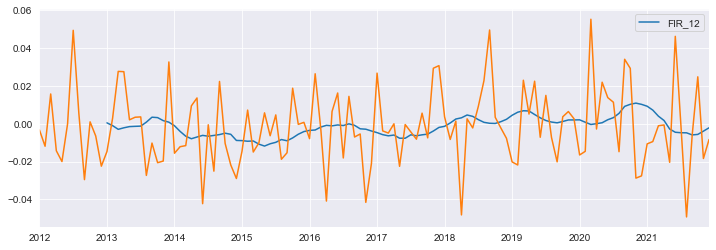

In [10]:
finfunc.filter_finite_impulse_response(ts_r, window=12).plot(legend=True)
ts_r.plot()

<AxesSubplot:>

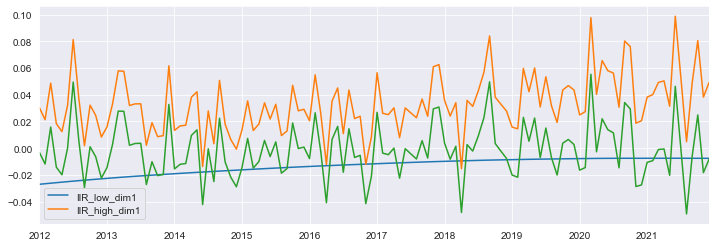

In [11]:
finfunc.filter_IIR_Butterworth(ts_r, dimension=1).plot(legend=True)
ts_r.plot()

In [12]:
# rolling features
w = 12
l_ = list()
for i in range(w, len(ts_r)+1):
    x = ts_r[i-w:i]
    l_.append((
        x.mean(),
        x.var(),
        x.skew(),
        x.kurt(),
        finfunc.fast_Fourier_transform(x, freq_cut=60)[-1],
        finfunc.filter_finite_impulse_response(x, window=6)[-1],
        finfunc.filter_IIR_Butterworth(x, dimension=1).iloc[0, -1],
        finfunc.filter_IIR_Butterworth(x, dimension=1).iloc[1, -1],
    ))

ts = ts.join(
    pd.DataFrame(l_, index=ts_r.index[w-1:],
                 columns=['mean', 'var', 'skew', 'kurt', 'fft', 'fir', 'iir_low', 'iir_high'])
)
ts

,price,return,hwm,mdd,mean,var,skew,kurt,fft,fir,iir_low,iir_high
2011-12-30,100.000000,NaN,100.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-31,99.678141,-0.003219,100.000000,-0.003219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-29,98.497723,-0.011842,100.000000,-0.015023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,100.054323,0.015803,100.054323,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-30,98.630001,-0.014235,100.054323,-0.014235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,80.962852,-0.049222,89.949701,-0.099910,-0.003196,0.000788,0.362999,-0.374957,0.005299,0.000193,0.085642,0.082946
2021-09-30,80.471865,-0.006064,89.949701,-0.105368,-0.006547,0.000650,0.617883,0.911132,-0.008698,0.001071,0.024550,-0.032556
2021-10-29,82.473435,0.024873,87.367622,-0.056018,-0.006920,0.000622,0.606070,1.129763,-0.014083,-0.002659,-0.057860,-0.057831
2021-11-30,80.962530,-0.018320,85.221082,-0.049971,-0.006055,0.000590,0.595386,1.477716,-0.013933,-0.006229,0.006248,0.022097


In [13]:
import statsmodels.api as sm
SARIMA_fit = sm.tsa.SARIMAX(ts_r, order=(
    3, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()
SARIMA_fit.summary()

/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78027D+00    |proj g|=  5.34687D+00

At iterate    5    f= -1.78968D+00    |proj g|=  2.42671D+00

At iterate   10    f= -1.95838D+00    |proj g|=  7.33534D+00

At iterate   15    f= -1.97810D+00    |proj g|=  5.91617D-01

At iterate   20    f= -2.01629D+00    |proj g|=  6.09991D+00

At iterate   25    f= -2.04463D+00    |proj g|=  1.29856D-01

At iterate   30    f= -2.05016D+00    |proj g|=  2.83792D+00

At iterate   35    f= -2.07575D+00    |proj g|=  3.66671D-01

At iterate   40    f= -2.08295D+00    |proj g|=  1.04322D+00

At iterate   45    f= -2.09034D+00    |proj g|=  6.15797D-02

At iterate   50    f= -2.09812D+00    |proj g|=  2.23726D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               return   No. Observations:                  120
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 251.774
Date:                              Sun, 27 Feb 2022   AIC                           -487.548
Time:                                      12:53:55   BIC                           -466.166
Sample:                                  01-31-2012   HQIC                          -478.880
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9101      0.208     -4.383      0.000      -1.317      -0.503
ar.L2         -0.1434      0.158     -0.906      0.365      -0.454       0.167
ar.L3         -0.1889      0.117     -1.609      0.108      -0.419       0.041
ma.L1         -0.0749      1.370     -0.055      0.956      -2.759       2.610
ma.L2         -0.9226      1.336     -0.691      0.490      -3.540       1.695
ar.S.L12      -0.0344      0.173     -0.199      0.842      -0.373       0.304
ma.S.L12      -0.8413      0.267     -3.150      0.002      -1.365      -0.318
sigma2         0.0004      0.001      0.743      0.458      -0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.65   Prob(JB):                         0.65
Heteroskedasticity (H):               1.16   Skew:                             0.20
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
SARIMA_fit.arparams,SARIMA_fit.maparams

(array([-0.91010076, -0.14340597, -0.18888256]),
 array([-0.07487601, -0.92258207]))

/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

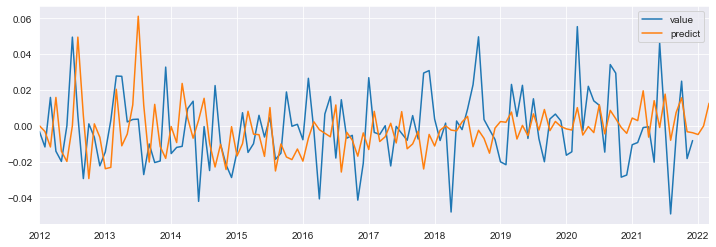

In [15]:
finfunc.statmodels_predict(SARIMA_fit, 3).plot()

<AxesSubplot:>

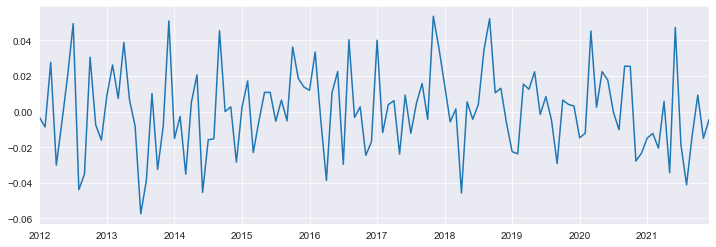

In [16]:
SARIMA_fit.resid.plot()

(<Figure size 864x288 with 1 Axes>, <Figure size 864x288 with 1 Axes>)

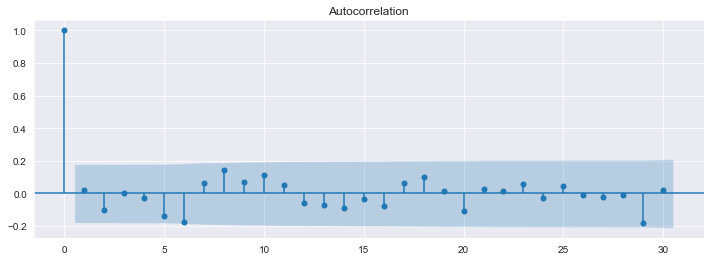

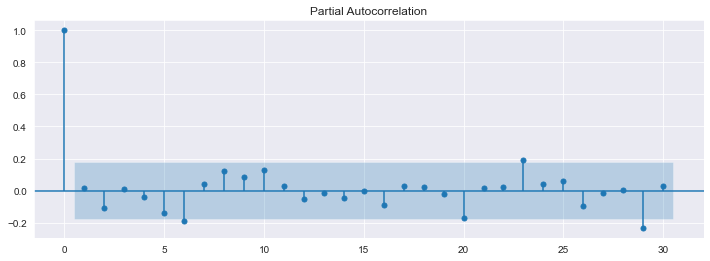

In [17]:
finfunc.acf_plot(SARIMA_fit.resid)

In [18]:
from sklearn.model_selection import train_test_split
ts_target = ts.shift(-1).dropna().iloc[1:, 1]  # 1month delay
ts_features = ts.dropna().iloc[:-1, 2:]  # 1month cut
ts_train_test = train_test_split(
    ts_features, ts_target, random_state=0, shuffle=False, test_size=0.2)
ts_features.tail(3)

,hwm,mdd,mean,var,skew,kurt,fft,fir,iir_low,iir_high
2021-09-30,89.949701,-0.105368,-0.006547,0.000650,0.617883,0.911132,-0.008698,0.001071,0.024550,-0.032556
2021-10-29,87.367622,-0.056018,-0.006920,0.000622,0.606070,1.129763,-0.014083,-0.002659,-0.057860,-0.057831
2021-11-30,85.221082,-0.049971,-0.006055,0.000590,0.595386,1.477716,-0.013933,-0.006229,0.006248,0.022097


features_model         DummyRegressor()
score                             -0.03
n_features_original                  10
coef                               None
intercept                          None
dtype: object


<AxesSubplot:>

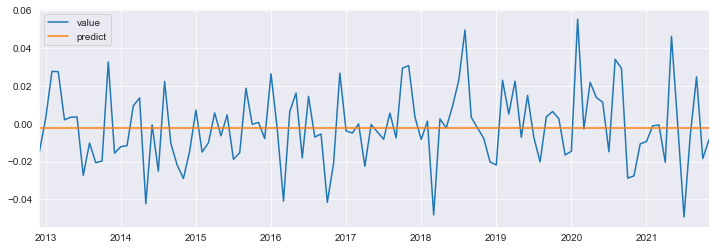

In [19]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy='mean')
finfunc.sklearn_predict_regression(dummy, ts_train_test).plot()

features_model                                        LinearRegression()
score                                                               0.02
n_features_original                                                   10
coef                   [-0.0, -0.02, 0.66, 6.85, 0.01, 0.0, -0.1, -1....
intercept                                                           0.03
dtype: object


<AxesSubplot:>

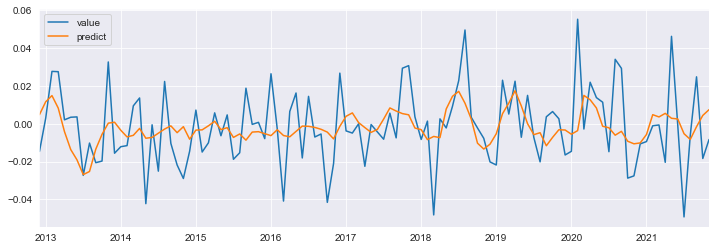

In [20]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
finfunc.sklearn_predict_regression(ols, ts_train_test).plot()

features_model                                          Ridge(alpha=0.5)
score                                                               0.03
n_features_original                                                   10
coef                   [-0.0, -0.01, -0.0, 0.0, 0.0, 0.0, -0.0, -0.01...
intercept                                                           0.01
dtype: object


<AxesSubplot:>

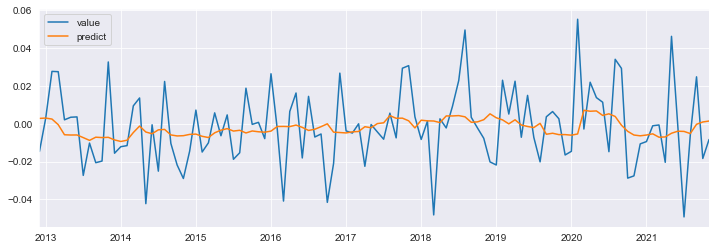

In [21]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.5)
finfunc.sklearn_predict_regression(ridge, ts_train_test).plot()

features_model         RFECV(estimator=LinearRegression(), scoring='n...
score                                                              -0.12
n_features_original                                                   10
coef                                                                None
intercept                                                           None
dtype: object


,hwm,mdd,mean,var,skew,kurt,fft,fir,iir_low,iir_high
flg,False,False,True,True,False,False,False,True,False,False
rank,8,6,1,1,7,5,2,1,4,3


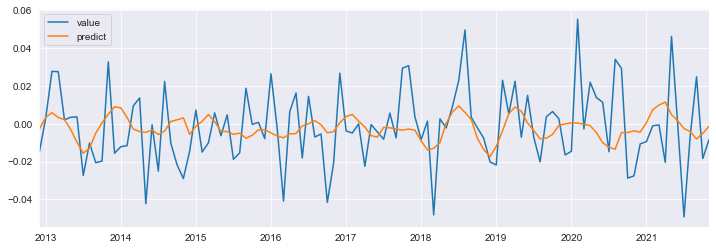

In [22]:
# 再帰的特徴量除去
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=ols, step=1, scoring="neg_mean_squared_error")
res = finfunc.sklearn_predict_regression(rfecv, ts_train_test)
res.plot()

# 維持すべき特徴量
pd.DataFrame({
    'flg': rfecv.support_,
    'rank': rfecv.ranking_
}, index=ts_train_test[0].columns).T

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import shap
shap.initjs()

def calc_scores(value, predict=None):
    if type(value) == pd.DataFrame:
        value, predict, *_ = value.values.T.tolist()
    return {
        'R2': r2_score(value, predict),
        'MAE': mean_absolute_error(value, predict),
        'RMSE': np.sqrt(mean_squared_error(value, predict)),
        'MAPE':np.mean(np.abs((predict - value) / value))
    }


def gbm_predict_regression(model, features, target):
    return pd.DataFrame({
        'value': target,
        'predict': model.predict(features)
    }, index=target.index)


def gbm_feature_importance(model):
    return pd.Series(np.array(model.feature_importance()),
                     index=model.feature_name()
                     ).sort_values(ascending=False)



def shap_values_plot(model, features, plot_type='bar'):
    explainer = shap.TreeExplainer(
        model=model,
        feature_perturbation='tree_path_dependent',
        model_output='raw')

    shap_values = explainer.shap_values(X=features)
    shap.summary_plot(shap_values, features, plot_type=plot_type)
    return shap_values

[10]	training's rmse: 0.0168567	valid_1's rmse: 0.0253323
[20]	training's rmse: 0.0156681	valid_1's rmse: 0.0258048
[30]	training's rmse: 0.0145917	valid_1's rmse: 0.0264961
[40]	training's rmse: 0.0137697	valid_1's rmse: 0.0271654
[50]	training's rmse: 0.0130955	valid_1's rmse: 0.02768
[60]	training's rmse: 0.0124727	valid_1's rmse: 0.0279691
[70]	training's rmse: 0.01205	valid_1's rmse: 0.0281575
[80]	training's rmse: 0.0115615	valid_1's rmse: 0.0284365
[90]	training's rmse: 0.0111632	valid_1's rmse: 0.0284822
[100]	training's rmse: 0.0108078	valid_1's rmse: 0.0286624
{'early_stopping_round': None,
 'learning_rate': None,
 'max_bin': None,
 'metric': 'rmse',
 'num_iterations': 100,
 'num_leaves': None,
 'objective': 'regression',
 'verbosity': -1}
{'R2': -0.3027200156712624, 'MAE': 0.021887302478135497, 'RMSE': 0.028662407210813215}


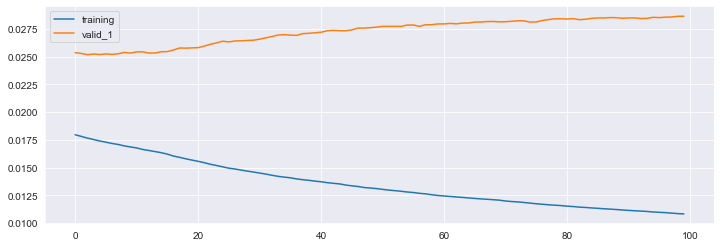

In [302]:
import lightgbm as lgb
from pprint import pprint as pprint
#from sklearn.metrics import accuracy_score, confusion_matrix


def train_LGBM(features, target, eval_f=None, eval_t=None, params={}):
    params_ = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'max_bin': None,
        'learning_rate': None,
        'num_leaves': None,
    }
    params_.update(params)

    train_lgb = lgb.Dataset(features, target)
    lgb_results = {}

    model = lgb.train(
        params=params_,
        train_set=train_lgb,
        valid_sets=[train_lgb,
                    lgb.Dataset(eval_f, eval_t, reference=train_lgb)],
        early_stopping_rounds=None,
        num_boost_round=100,
        verbose_eval=10,
        evals_result=lgb_results,
    )
    pprint(model.params)
    pd.concat([pd.DataFrame({i: lgb_results[i][model.params['metric']]})
              for i in lgb_results.keys()], axis=1).plot()
    return model


def q_LGBM(ts_train_test, param={}):
    model = train_LGBM(ts_train_test[0], ts_train_test[2],
                       ts_train_test[1], ts_train_test[3], param)
    res = gbm_predict_regression(model, ts_train_test[1], ts_train_test[3])
    print(calc_scores(res))
    # res.plot()
    # gbm_feature_importance(model).plot.bar()
    return model


def qq_LGBM(ts_list, param={}):
    param_d = {'metric': 'rmse', 'verbosity': 0}
    param_d.update(param)
    model = lgb.LGBMRegressor(**param_d,)
    model.fit(ts_list[0], ts_list[2],
              eval_set=[(ts_list[1], ts_list[3]), (ts_list[0], ts_list[2])])
    pprint(model.get_params())
    lgb.plot_metric(model)
    lgb.plot_importance(model)
    return model


param_a = {
    'learning_rate': 0.05,
    'max_bin': 50,
    'num_leaves': 5,
    'objective': 'regression',
    'verbosity': -1}


m = q_LGBM(ts_train_test)

[1]	training's rmse: 0.0180819	valid_0's rmse: 0.0254695
[2]	training's rmse: 0.0179863	valid_0's rmse: 0.0254403
[3]	training's rmse: 0.0179168	valid_0's rmse: 0.0254311
[4]	training's rmse: 0.0178312	valid_0's rmse: 0.0254062
[5]	training's rmse: 0.0177681	valid_0's rmse: 0.0254335
[6]	training's rmse: 0.0176886	valid_0's rmse: 0.0253882
[7]	training's rmse: 0.0176157	valid_0's rmse: 0.02537
[8]	training's rmse: 0.0175578	valid_0's rmse: 0.0253976
[9]	training's rmse: 0.0174899	valid_0's rmse: 0.0253594
[10]	training's rmse: 0.017437	valid_0's rmse: 0.0253868
[11]	training's rmse: 0.0173442	valid_0's rmse: 0.0254139
[12]	training's rmse: 0.0172852	valid_0's rmse: 0.0253818
[13]	training's rmse: 0.0172358	valid_0's rmse: 0.0254094
[14]	training's rmse: 0.0171683	valid_0's rmse: 0.0254699
[15]	training's rmse: 0.0171225	valid_0's rmse: 0.0254973
[16]	training's rmse: 0.0170703	valid_0's rmse: 0.0254737
[17]	training's rmse: 0.0170272	valid_0's rmse: 0.0255009
[18]	training's rmse: 0.01

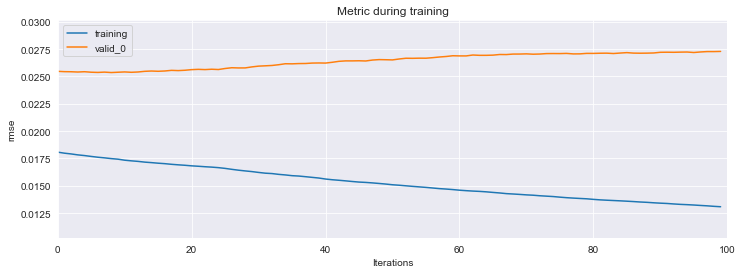

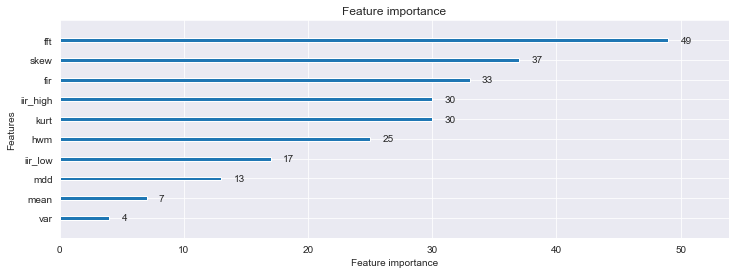

In [305]:
m = qq_LGBM(ts_train_test, param_a)

In [313]:
calc_scores(gbm_predict_regression(
    m, ts_train_test[1], ts_train_test[3]))

{'R2': -0.180901762355701,
 'MAE': 0.02075832104072075,
 'RMSE': 0.02728940107235813}

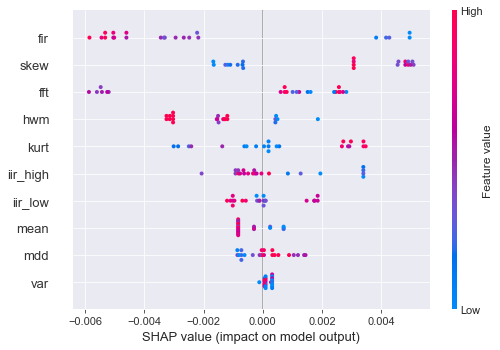

In [306]:
_=shap_values_plot(m, ts_train_test[1], None)

<AxesSubplot:>

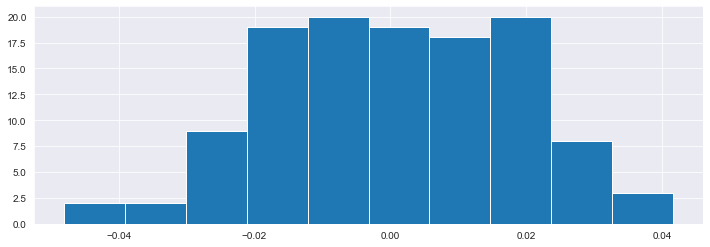

In [10]:
ts_r.hist()

In [39]:
ts_r[np.abs(ts_r) > np.mean(ts_r)+2*np.std(ts_r)]

2014-05-30    0.041627
2019-08-30   -0.048058
2020-07-31   -0.042661
2020-12-31    0.040391
Name: return, dtype: float64

In [48]:
def outliers(value, threshold=3):
    return np.abs(value) < (np.mean(value)+threshold*np.std(value))


outliers(ts_r, 2).value_counts()

True     116
False      4
Name: return, dtype: int64

In [51]:
ts_r[outliers(ts_r, 2)]

2012-01-31   -0.013494
2012-02-29   -0.004833
2012-03-30   -0.020127
2012-04-30    0.005166
2012-05-31    0.012162
                ...   
2021-08-31    0.007416
2021-09-30   -0.007908
2021-10-29   -0.003152
2021-11-30   -0.010513
2021-12-31   -0.002747
Name: return, Length: 116, dtype: float64